# TÜBITAK FRED API ANALYSIS

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# plt.style.use('fivethirtyeight')
# pd.set_option('max_columns', 500)
# color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

# API Connection

fred_api_key = '0649cf7628aff22c791f8eba7e48597e'
fred = Fred(api_key=fred_api_key)

In [7]:
# Function to pull specific economic indicators

def fetch_data(series_id):
    try:
        data = fred.get_series(series_id)
        df = pd.DataFrame(data, columns = ["Value"])
        df.index.name = "Date"
        return df
    except Exception as e:
        print(f"Couldn't fetch data for {series_id}: {e}")
        return pd.DataFrame()

In [8]:
# FRED API series and definitions

series_mapping = {
    "Unemployment Rate" : "UNRATE",
    "GDP": "GDP",
    "Inflation (CPI)": "CPIAUCSL",
    "Federal Funds Rate": "FEDFUNDS",
    "S&P 500": "SP500",
    "10-Year Treasury Rate": "GS10",
    "Personal Consumption Expenditures": "PCE",
    "Housing Starts": "HOUST",
    "Retail Sales": "RSAFS",
    "Consumer Confidence Index": "UMCSENT",
    "Industrial Production": "INDPRO",
    "Total Nonfarm Employment": "PAYEMS"
    }

In [9]:
# User selection to analyze indicators

indicators = list(series_mapping.keys())
dataframes = {}

In [10]:
# Pull data for selected indicators

for indicator in indicators:
    series_id = series_mapping.get(indicator)
    if series_id:
        df = fetch_data(series_id)
        if not df.empty:
            dataframes[indicator] = df

In [13]:
# Processing and analyzing data

if dataframes:
    # Combining indicators
    combined_df = pd.concat(dataframes.values(), axis = 1, keys = dataframes.keys())
    combined_df.columns.names = ["Indicator", "Metrics"]

    print("Combined data:")
    print(combined_df.head())

Combined data:
Indicator  Unemployment Rate   GDP Inflation (CPI) Federal Funds Rate S&P 500  \
Metrics                Value Value           Value              Value   Value   
Date                                                                            
1919-01-01               NaN   NaN             NaN                NaN     NaN   
1919-02-01               NaN   NaN             NaN                NaN     NaN   
1919-03-01               NaN   NaN             NaN                NaN     NaN   
1919-04-01               NaN   NaN             NaN                NaN     NaN   
1919-05-01               NaN   NaN             NaN                NaN     NaN   

Indicator  10-Year Treasury Rate Personal Consumption Expenditures  \
Metrics                    Value                             Value   
Date                                                                 
1919-01-01                   NaN                               NaN   
1919-02-01                   NaN                        

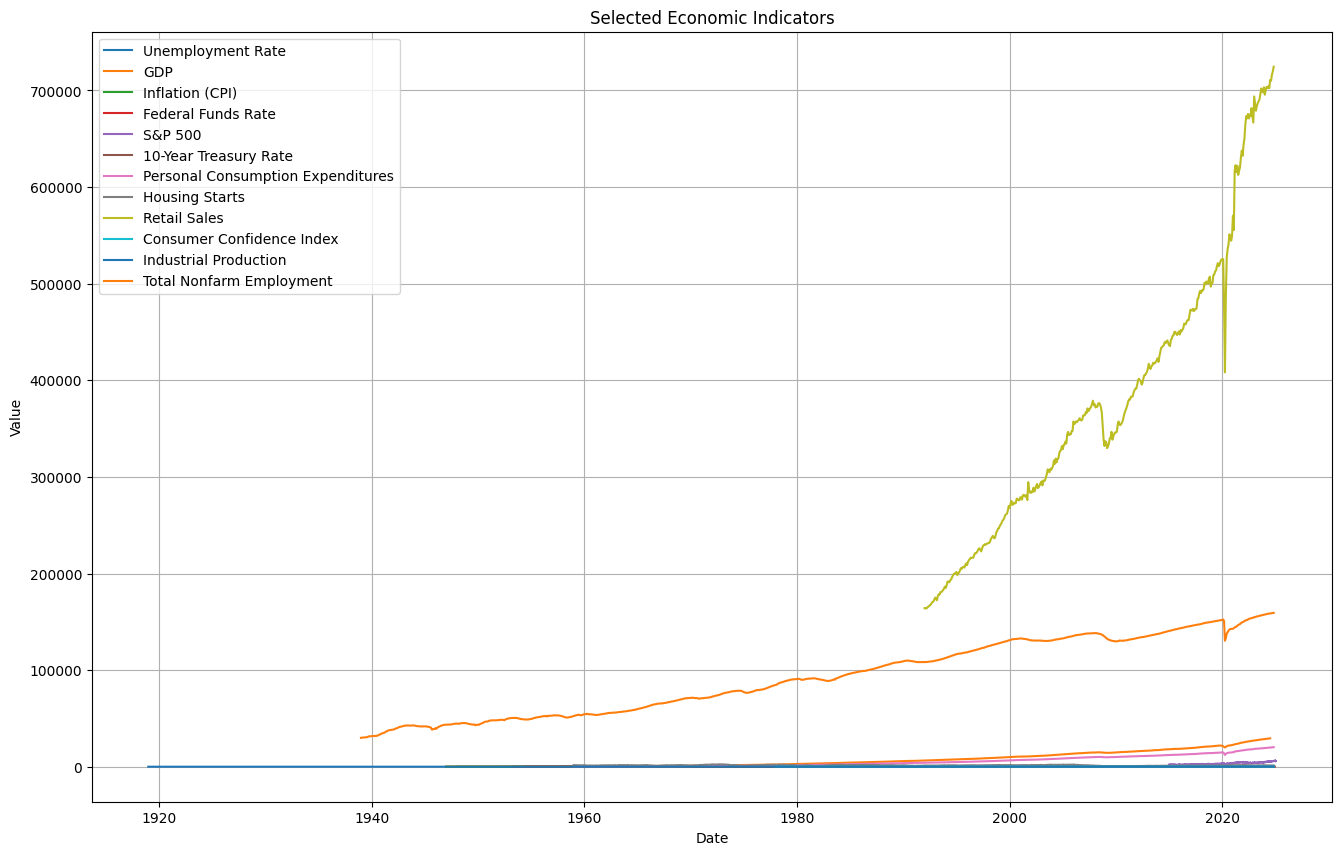

In [19]:
# Graph drawing

plt.figure(figsize=(16, 10))
for indicator, df in dataframes.items():
        plt.plot(df.index, df["Value"], label=indicator)
plt.title("Selected Economic Indicators")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()


In [20]:
    # Correlation analysis

    print("Correlation matrix:")
    correlation_matrix = combined_df.corr()
    print(correlation_matrix)

Correlation matrix:
Indicator                                 Unemployment Rate       GDP  \
Metrics                                               Value     Value   
Indicator                         Metrics                               
Unemployment Rate                 Value            1.000000  0.004018   
GDP                               Value            0.004018  1.000000   
Inflation (CPI)                   Value            0.083313  0.975823   
Federal Funds Rate                Value            0.063444 -0.452254   
S&P 500                           Value           -0.213502  0.971571   
10-Year Treasury Rate             Value            0.311202 -0.471225   
Personal Consumption Expenditures Value           -0.147627  0.999725   
Housing Starts                    Value           -0.322761 -0.273818   
Retail Sales                      Value           -0.264073  0.994670   
Consumer Confidence Index         Value           -0.384732 -0.158557   
Industrial Production          

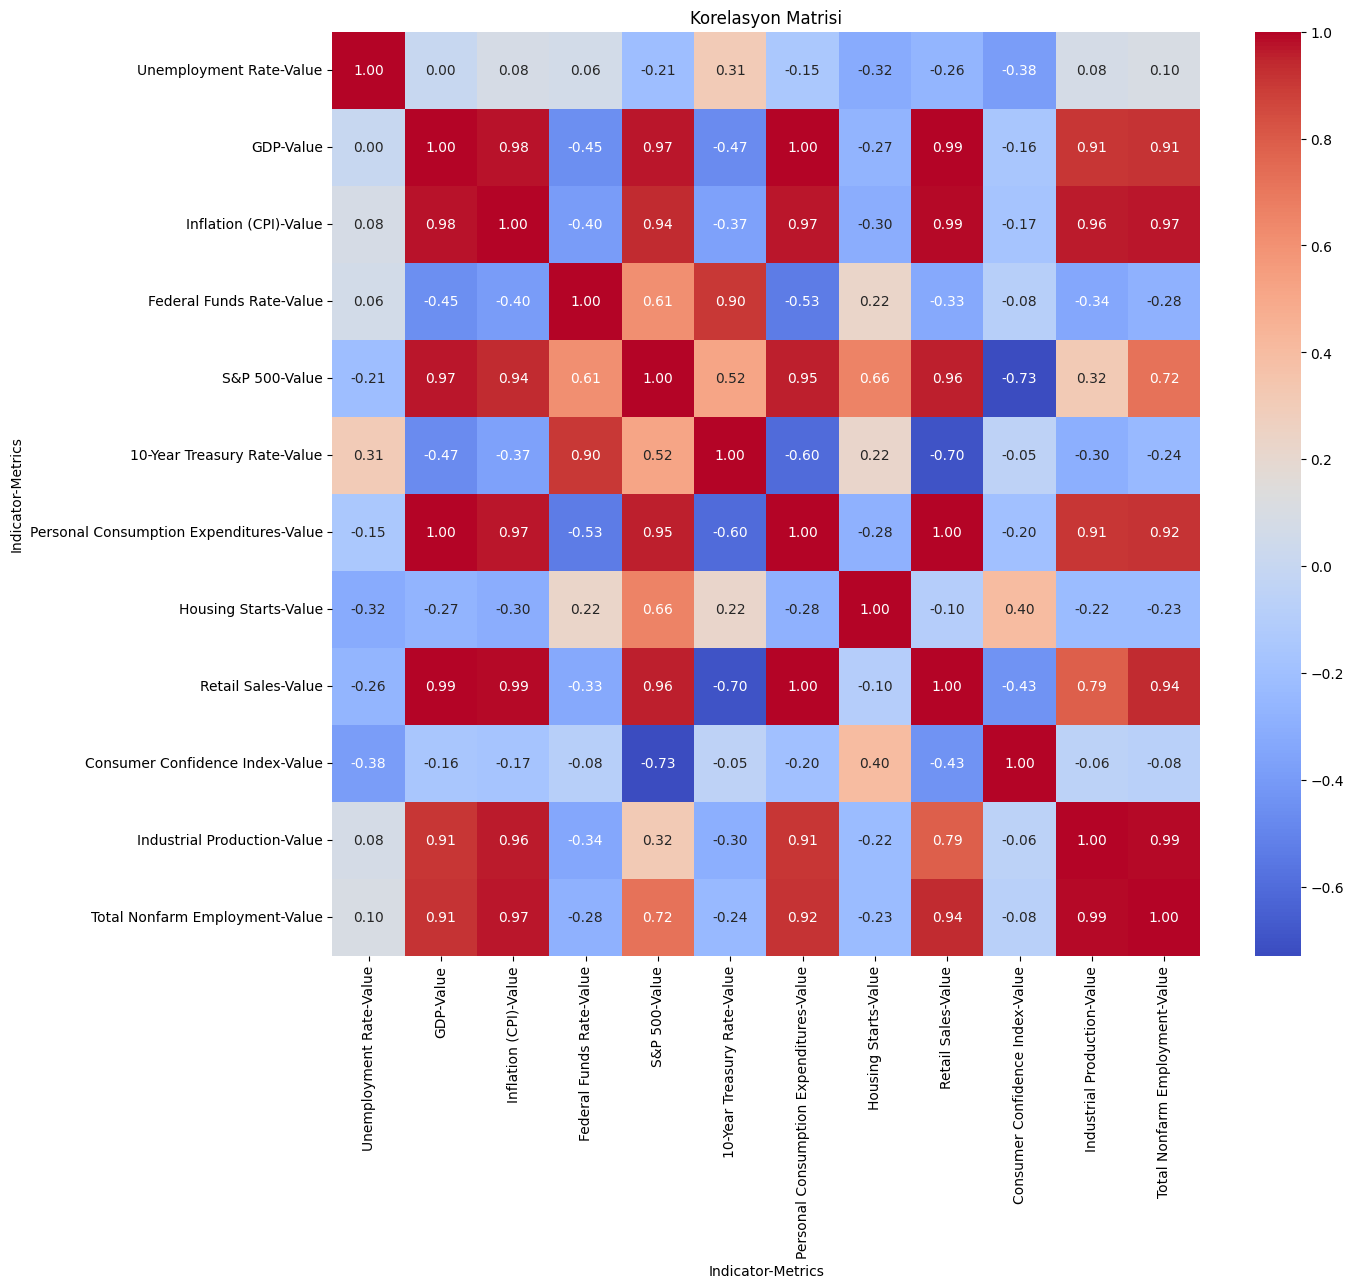

In [ ]:
# Correlation visualization

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Korelasyon Matrisi")
plt.show()

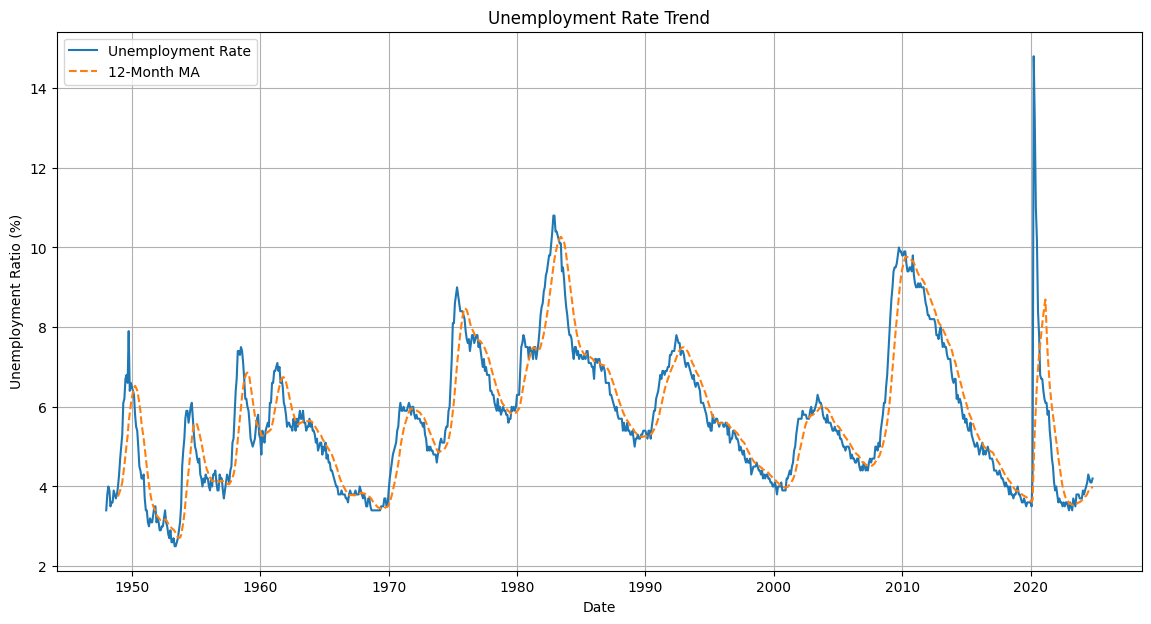

In [29]:
# Unemployment analysis

unemployment_df = dataframes.get("Unemployment Rate")
if unemployment_df is not None:
    unemployment_df["12-Month Moving Average"] = unemployment_df["Value"].rolling(window=12).mean()

plt.figure(figsize=(14, 7))
plt.plot(unemployment_df.index, unemployment_df["Value"], label="Unemployment Rate")
plt.plot(unemployment_df.index, unemployment_df["12-Month Moving Average"], linestyle="--", label="12-Month MA")
plt.title("Unemployment Rate Trend")
plt.xlabel("Date")
plt.ylabel("Unemployment Ratio (%)")
plt.legend()
plt.grid()
plt.show()


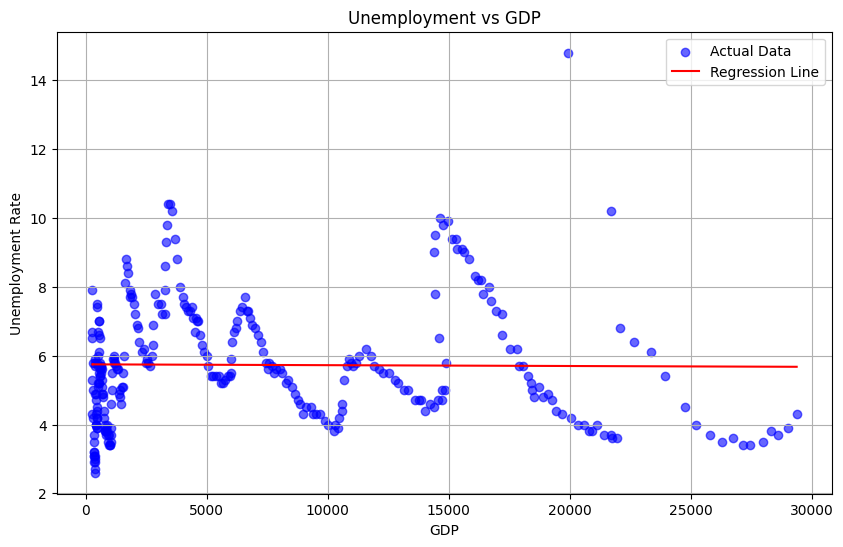

Coefficient: -2.4243916199893817e-06


In [ ]:
# Regression analysis between unemployment and GDP

if "GDP" in dataframes:
            gdp_df = dataframes["GDP"].copy()
            merged_df = pd.merge(unemployment_df, gdp_df, left_index=True, right_index=True, suffixes=("_Unemployment", "_GDP"))
            merged_df.dropna(inplace=True)

            X = merged_df["Value_GDP"].values.reshape(-1, 1)
            y = merged_df["Value_Unemployment"].values

            model = LinearRegression()
            model.fit(X, y)

            predictions = model.predict(X)
            plt.figure(figsize=(10, 6))
            plt.scatter(X, y, label="Actual Data", color="blue", alpha=0.6)
            plt.plot(X, predictions, label="Regression Line", color="red")
            plt.title("Unemployment vs GDP")
            plt.xlabel("GDP")
            plt.ylabel("Unemployment Rate")
            plt.legend()
            plt.grid()
            plt.show()

            print("Coefficient:", model.coef_[0])

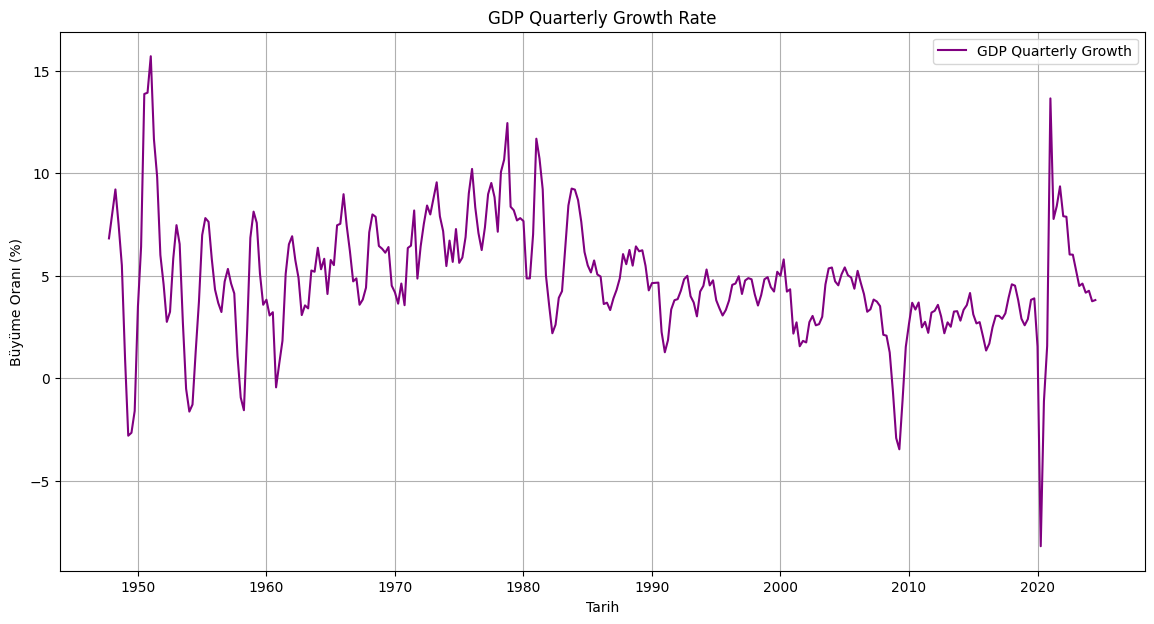

In [32]:
# GDP growth rate analysis

if "GDP" in dataframes:
        gdp_df = dataframes["GDP"]
        gdp_df["Quarterly Growth"] = gdp_df["Value"].pct_change(periods=3) * 100
        plt.figure(figsize=(14, 7))
        plt.plot(gdp_df.index, gdp_df["Quarterly Growth"], label="GDP Quarterly Growth", color="purple")
        plt.title("GDP Quarterly Growth Rate")
        plt.xlabel("Tarih")
        plt.ylabel("Büyüme Oranı (%)")
        plt.legend()
        plt.grid()
        plt.show()

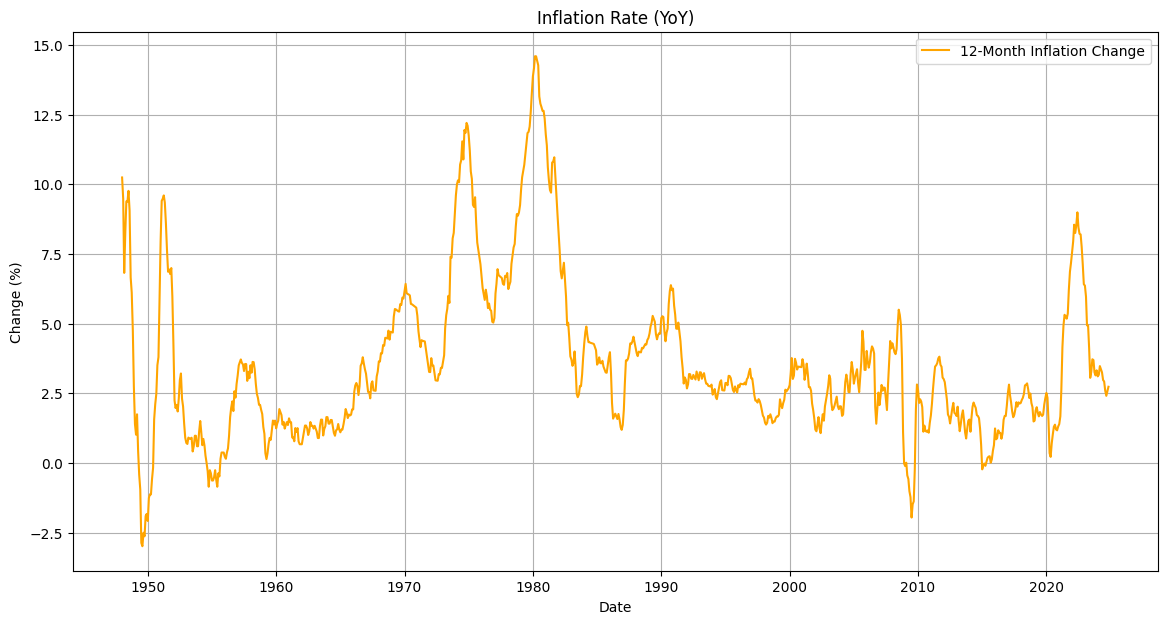

In [34]:
# Inflation analysis

inflation_df = dataframes.get("Inflation (CPI)")
if inflation_df is not None:
        inflation_df["12-Month Change"] = inflation_df["Value"].pct_change(periods=12) * 100
        plt.figure(figsize=(14, 7))
        plt.plot(inflation_df.index, inflation_df["12-Month Change"], label="12-Month Inflation Change", color="orange")
        plt.title("Inflation Rate (YoY)")
        plt.xlabel("Date")
        plt.ylabel("Change (%)")
        plt.legend()
        plt.grid()
        plt.show()

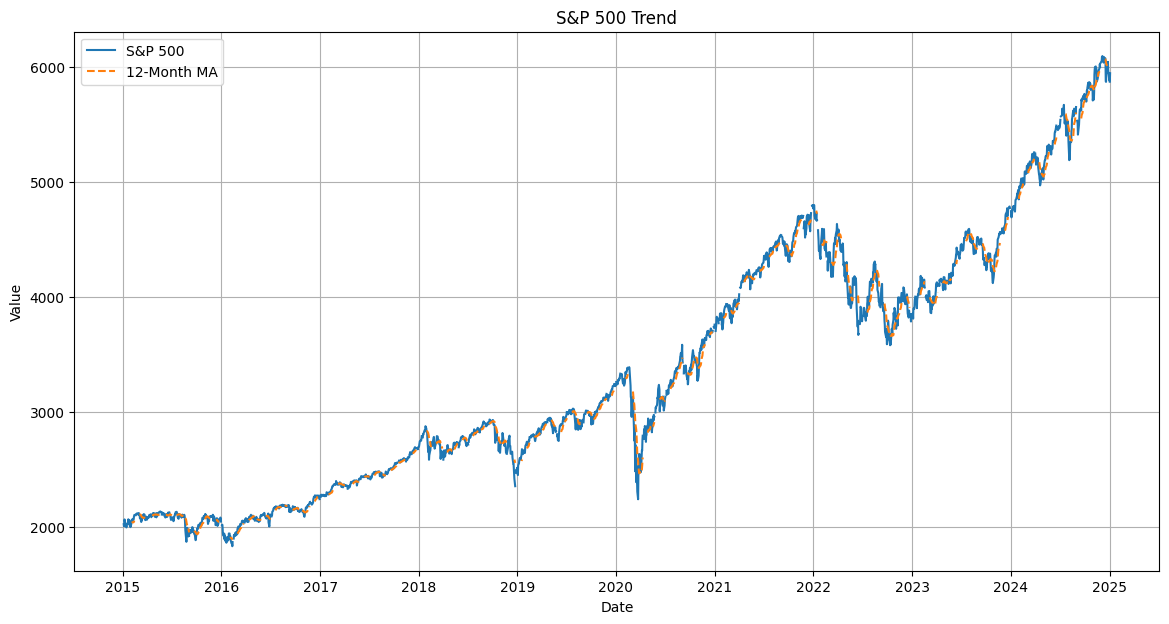

In [36]:
# Stock market analysis (S&P 500)

sp500_df = dataframes.get("S&P 500")
if sp500_df is not None:
        sp500_df["12-Month Moving Average"] = sp500_df["Value"].rolling(window=12).mean()
        plt.figure(figsize=(14, 7))
        plt.plot(sp500_df.index, sp500_df["Value"], label="S&P 500")
        plt.plot(sp500_df.index, sp500_df["12-Month Moving Average"], linestyle="--", label="12-Month MA")
        plt.title("S&P 500 Trend")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()
        plt.show()


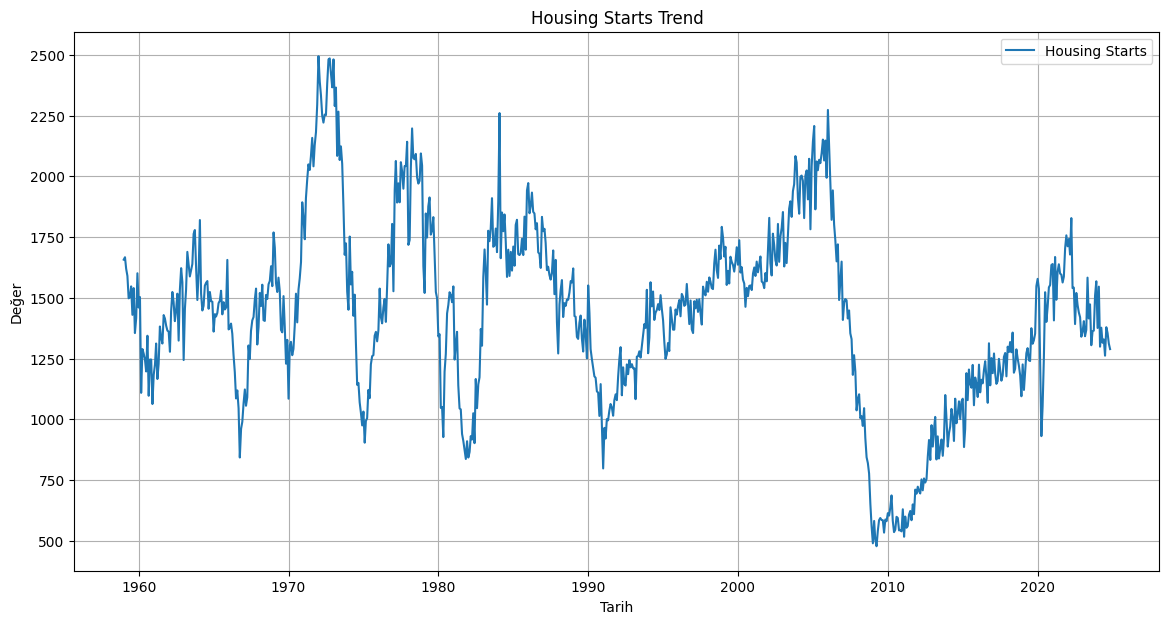

In [37]:
# Housing Starts analizi

housing_df = dataframes.get("Housing Starts")
if housing_df is not None:
        plt.figure(figsize=(14, 7))
        plt.plot(housing_df.index, housing_df["Value"], label="Housing Starts")
        plt.title("Housing Starts Trend")
        plt.xlabel("Tarih")
        plt.ylabel("Değer")
        plt.legend()
        plt.grid()
        plt.show()